<a href="https://colab.research.google.com/github/COFAlumni-USB/Physics-REBoot-Applied-Science-Bootcamp/blob/main/Hands%20On/Dia%205/Estimacion_Incertidumbre_Montecarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

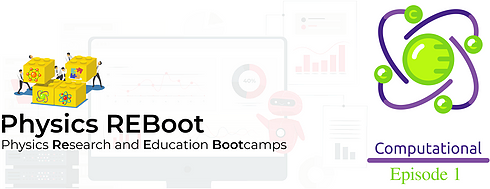

<h1>Physics Research and Education Bootcamp - Computational | Episode 1<h1>

License: CC BY-NC-SA  https://creativecommons.org/licenses/by-nc-sa/4.0/

Last Modification: Sept. 3, 2021

# ***Preambulo***

Primero carguemos los paquetes de Python necesarios para trabajar.

In [1]:
import numpy as np
from tqdm import tqdm # Si eres impaciente como yo querras saber cuanto tiempo falta para que un codigo termine de ejecutarse
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# **Estimación de Incertidumbre en Modelos Computacionales con *Montecarlo***

\\

El método Montecarlo tiene otras aplicaciones ademas de estimar el valor esperado de una variable o área. En el caso de tener un modelo complejo en el cual la relación entre las variables y su impacto en el output del modelo no sean aparentes, o simples de computar, a través de Montecarlo podemos tener una estimado de la propagación de incertidumbre entre los inputs y outputs.

\\

Esto es de mucho interés ya que en la la vida diaria nos encontramos con problemas para los cuales tenemos modelos y una idea de los valores de sus parametros. Sin embargo estos parametros pueden ser inciertos y su valor real variar en un cierto intervalo.


# **Teoría**

En el caso del Modelo ***SIR***, los parámetros $\beta,\mu,\nu$ son las cantidades libres del modelo. En el caso de que quisieramos hacer un fit, estos son los parámetros que obtendriamos del fit, condicional a que el modelo describa los datos medidos.

\\

Recordando, a traves de Montecarlo podemos estimar el valor de una cantidad a través de:

\\

$\langle x \rangle = \frac{1}{M}\sum_{i=1}^{M} x$

\\

La desviación estándard de este estimador esta dada por:

$ \sigma = \frac{1}{\sqrt{M}}$

\\

En nuestro modelo, podemos estar interesados en ciertas propiedades como:

* El tiempo cuando se alcanzó el número máximo de infecciones $T_{max-inf}$.
* El número máximo de personas infectadas $N_{inf-max}$.
* El número máximo de personas recuperadas $N_{rec-max}$
* El día cuando el número de personas recuperadas es máximo $T_{max-rec}$

\\

Estimar la incertidumbre sobre estas cantidades es determinar la distribución de datos a posteriori (No un estimado puntual de la media y/o desviación estandard). Para esto es necesario asignar una distribución de probabilidad a cada uno de los parámetros arriba mencionados y evaluar los resultados de cada cantidad de interés al correr el modelo con esos parámetros.

Para empezar, debemos crear un código que nos permita generar escenarios...


# Práctica

Ya hemos resulto este problema. Nada nuevo aquí.

In [ ]:
def f_SIR(t,y,beta,nu,mu):
    """
    Descripcion matematica del modelo SIR para integrar
    """
    S = y[0] 
    I = y[1]
    R = y[2]
    S_dot = -beta*S*I + mu*R
    I_dot = beta*S*I - nu*I
    R_dot = nu*I- mu*R
    return np.array([S_dot,I_dot,R_dot])


Luego tenemos que integrar esto. Esto lo solucionamos previamente

In [ ]:
def Solucionar(Constants,X0):
  results = solve_ivp(f_SIR,(0,10000),X0,args=Constants,rtol=1e-8)
  return results.t,results.y

Queremos ahora una función que evalue el resultado (un array con el numero de infectados, recuperados y sanos como funcion del tiempo) y determine los cantidades máximas.

In [ ]:
def max_data(t,y):
    """

    Parameters
    ----------
    t : float array
        Array con los valores del tiempo.
    y : float array
        Array con los valores de y 
        (numero de infectados/recuperados/sanos).

    Returns
    -------
    t[idx] : float
        el tiempo cuando y es maximo.
    y[idx] : float
        el valor máximo del array a considerar.

    """
    idx = np.argmax(y)
    return t[idx],y[idx]

Ahora creamos un código wrapper que nos permita evaluar este solucionador utilizando distintos parámetros

In [ ]:
def Montecarlo(N_simulaciones,valores_medios,error_relativo):
  """
  En nuestro caso modelaremos cada parametro con una distribucion normal centrada alrededor de los valores medios


  valores_medios : array 3x1
    Contiene los valores medios de las distribuciones normales para [beta,nu,mu]
  
  error_relativo : 

  """
  # Una manera:
  mu_b = valores_medios[0]
  mu_n = valores_medios[1]
  mu_m = valores_medios[2]

  b = np.random.normal(mu_b,mu_b*error_relativo,size=N_simulaciones) # Average number of contacts per individual
  n = np.random.normal(mu_n,mu_n*error_relativo,size=N_simulaciones) # recovery rate
  m = np.random.normal(mu_m,mu_m*error_relativo,size=N_simulaciones) # loss of inmunity rate

  # Alternativamente (Preferiblemente):
  varianzas = (error_relativo * valores_medios)**2 # Calculamos la varianza para cada cantidad
  Covarianza = np.eye(3) # Creamos una matrix cuadrad 3x3 con 1's en la diagonal
  np.fill_diagonal(Covarianza,varianzas) # Llenamos la diagonal con el las varianzas que calculamos arriba
  Param = np.random.multivariate_normal(valores_medios,Covarianza,size=N_simulaciones)

  T_max_infected = []
  N_max_infected = []
  T_max_recovered = []
  N_max_recovered = []

  X0 = [90,10,0]
  
  #Res = [Solucionar(Param[i],X0) for i in tqdm(range(N_simulaciones))]
  #Max_infected = np.array([max_data(Res[i][0],Res[i][1][1]) for i in range(N_simulaciones)])
  #Max_recovered = np.array([max_data(Res[i][0],Res[i][1][2]) for i in range(N_simulaciones)])

  #T_max_infected = Max_infected[:,0]
  #N_max_infected = Max_infected[:,1]
  #T_max_recovered = Max_recovered[:,0]
  #N_max_recovered = Max_recovered[:,1]

  for i in tqdm(range(N_simulaciones)):
        results = Solucionar(Param[i],X0)
        t_max_infected,y_max_infected = max_data(results[0],results[1][1])
        t_max_recovered,y_max_recovered = max_data(results[0],results[1][2])
        T_max_infected.append(t_max_infected)
        N_max_infected.append(y_max_infected)
        T_max_recovered.append(t_max_recovered)
        N_max_recovered.append(y_max_recovered)

  return T_max_infected, N_max_infected, T_max_recovered, N_max_recovered

Evaluando este código `10000` veces con los valores propuestos para los parametros durante el bootcamp y `10%` de error relativo:

* $\beta$ = `0.03`
* $\nu$ = `0.01`
* $\mu$ = `0.001`

In [ ]:
TmaxI,NmaxI,TmaxR,NmaxR = Montecarlo(10000,np.array([0.03,0.01,0.001]),0.1)

100%|██████████| 10000/10000 [22:56<00:00,  7.26it/s]


Podemos graficar estos resultados y ver los histogramas

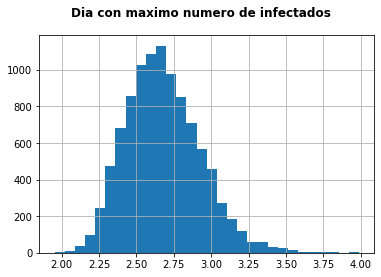

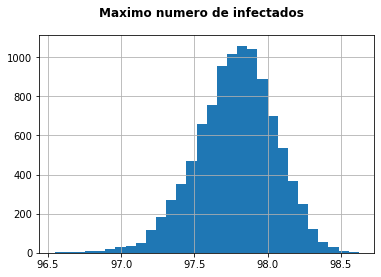

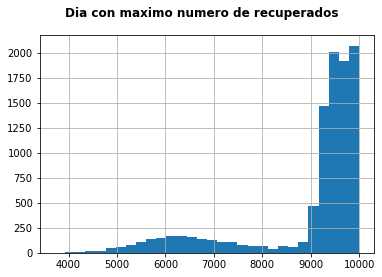

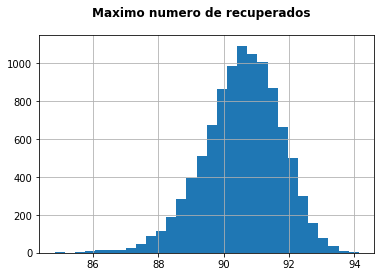

In [ ]:
plt.figure()
plt.suptitle('Dia con maximo numero de infectados',
              fontweight='bold')
plt.hist(TmaxI,30)
plt.grid(True)

plt.figure()
plt.suptitle('Maximo numero de infectados',
              fontweight='bold')
plt.hist(NmaxI,30)
plt.grid(True)

plt.figure()
plt.suptitle('Dia con maximo numero de recuperados',
              fontweight='bold')
plt.hist(TmaxR,30)
plt.grid(True)

plt.figure()
plt.suptitle('Maximo numero de recuperados',
              fontweight='bold')
plt.hist(NmaxR,30)
plt.grid(True)

# ***Discusión***

Que podemos aprender y entender de esto?

# Tarea

Generalice el código que hemos desarrollado para el modelo ***SEIR***. Pruebe con distintos tipos de distribuciones para el muestreo de los parametros.

Version 1.0, Autor: Antonio Figueroa

In [2]:
#libs summary
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'IPython.core.shadowns',
 'numpy',
 'matplotlib.pyplot',
 'types']